# Data Visualization for Expensive Restaurants 

Reference: <br>
Wendy Kan's notebook:
https://www.kaggle.com/wendykan/yelp-restaurant-photo-classification/expensive-restaurants-look-like-this

## Load Data

In [1]:
import numpy as np
import pandas as pd 

data_root = '/home/ncchen/Kaggle-Yelp/input/'

train_photos = pd.read_csv(data_root+'train_photo_to_biz_ids.csv')
train_photo_to_biz = pd.read_csv(data_root+'train_photo_to_biz_ids.csv', index_col='photo_id')

train_df = pd.read_csv(data_root+"train_biz_features.csv")  #This is the 1000-dim probability feature, not fc7 feature
test_df  = pd.read_csv(data_root+"test_biz_features.csv")

y_train = train_df['label'].values
X_train = train_df['feature vector'].values
X_test = test_df['feature vector'].values

def convert_label_to_array(str_label):
    str_label = str_label[1:-1]
    str_label = str_label.split(',')
    return [int(x) for x in str_label if len(x)>0]

def convert_feature_to_vector(str_feature):
    str_feature = str_feature[1:-1]
    str_feature = str_feature.split(',')
    return [float(x) for x in str_feature]

y_train = np.array([convert_label_to_array(y) for y in train_df['label']])
X_train = np.array([convert_feature_to_vector(x) for x in train_df['feature vector']])
X_test = np.array([convert_feature_to_vector(x) for x in test_df['feature vector']])

## Q: What're the top 5 ImageNet-labels in an expensive restaurant?

In [2]:
# load labels used in the ILSVRC12 model
caffe_root = '/home/ncchen/caffe/' 
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
ImageNetLabels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
ImageNetLabels = np.array([x[10:] for x in ImageNetLabels])  #Ignore the first 9 irrelavant characters

def lookup_top_labels(vector, k=5):
# sort top k predictions from probability vector
    top_k = list(vector.flatten().argsort()[-1:-(k+1):-1])
    return list(ImageNetLabels[top_k])

#############################  Yelp Attributes #############################
#0: good_for_lunch                    5: has_alcohol
#1: good_for_dinner                   6: has_table_service  
#2: takes_reservations                7: ambience_is_classy
#3: outdoor_seating                   8: good_for_kids
#4: restaurant_is_expensive
############################################################################

In [3]:
expensive_biz_index =  np.array([i for i in range(X_train.shape[0]) if 4 in y_train[i]])
expensive_biz_features = X_train[np.random.choice(expensive_biz_index,5)]


### Randomly choose 5 expensive restaurants and show its top 5 labels
print "Five randomly chosen expensive restaurants: \n"
for feature in expensive_biz_features:
    print lookup_top_labels(feature)     

### Mean of the probability vectors among all expensive restaurant
expensive_mean_feature = np.mean(X_train[expensive_biz_index],axis=0)
print "\n\n Expensive restaurant average: \n"
print lookup_top_labels(expensive_mean_feature) 

Five randomly chosen expensive restaurants: 

['plate', 'consomme', 'chocolate sauce, chocolate syrup', 'ice cream, icecream', 'candle, taper, wax light']
['plate', 'meat loaf, meatloaf', 'restaurant, eating house, eating place, eatery', 'chocolate sauce, chocolate syrup', 'mashed potato']
['plate', 'meat loaf, meatloaf', 'ice cream, icecream', 'mashed potato', 'restaurant, eating house, eating place, eatery']
['plate', 'restaurant, eating house, eating place, eatery', 'consomme', 'carbonara', 'menu']
['plate', 'restaurant, eating house, eating place, eatery', 'consomme', 'carbonara', 'tobacco shop, tobacconist shop, tobacconist']


 Expensive restaurant average: 

['plate', 'consomme', 'restaurant, eating house, eating place, eatery', 'meat loaf, meatloaf', 'chocolate sauce, chocolate syrup']


## t-SNE Visualization

The following code is adopted from Alexander Fabisch, http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html

Other references: <br>
(1) Laurens van der Maaten, https://lvdmaaten.github.io/tsne/  <br>
(2) Andrej Karpathy, http://cs.stanford.edu/people/karpathy/cnnembed/ <br>
(3) Lecture Slides: http://cs231n.stanford.edu/slides/winter1516_lecture9.pdf#page=12 <br>

### Load Data

In [4]:
data_root = '/home/ncchen/Kaggle-Yelp/input/'

import numpy as np
import pandas as pd 
import h5py

## Load image features
file = h5py.File(data_root+'train_image_features.h5','r')
image_features = np.copy(file['feature'])
images_id = np.copy(file['photo_id'])
file.close()

train_attr = pd.read_csv(data_root+'/train.csv')
train_attr['labels_list'] = train_attr['labels'].str.split(' ')
# find all the restaurants that are expensive (label=4)
train_attr['is_expensive'] = train_attr['labels'].str.contains('4')
expensive_biz = train_attr[train_attr.is_expensive==True].business_id.tolist()
expensive_photos = train_photos[train_photos.business_id.isin(expensive_biz)].photo_id.tolist()
expensive_photos500 = np.random.choice(expensive_photos,50)

images_id_short= [int(x.split("/")[-1][:-4]) for x in images_id]
expensive_photos_index = [images_id_short.index(x) for x in expensive_photos500]
expensive_features500 = image_features[expensive_photos_index]
expensive_images = images_id[expensive_photos_index]

### t-SNE Embeds high-dimensional feature vectors to 2D plane

In [5]:
from sklearn.manifold import TSNE

#help(TSNE) 

X_train = expensive_features500
from sklearn.decomposition import PCA
X_train = PCA(n_components=50).fit_transform(X_train)
X_train_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.586046
[t-SNE] Iteration 25: error = 1.0323653, gradient norm = 0.0023502
[t-SNE] Iteration 50: error = 0.9571382, gradient norm = 0.0017691
[t-SNE] Iteration 75: error = 0.8515481, gradient norm = 0.0009221
[t-SNE] Iteration 75: gradient norm 0.000922. Finished.
[t-SNE] Error after 75 iterations with early exaggeration: 0.851548
[t-SNE] Iteration 100: error = 0.8010021, gradient norm = 0.0007879
[t-SNE] Iteration 100: gradient norm 0.000788. Finished.
[t-SNE] Error after 100 iterations: 0.801002


### Plot it      (Only 50 pictures are shown here to keep file size small)

Populating the interactive namespace from numpy and matplotlib


Number of images shown:  50
Saved to: tSNE_expensive_biz.jpg


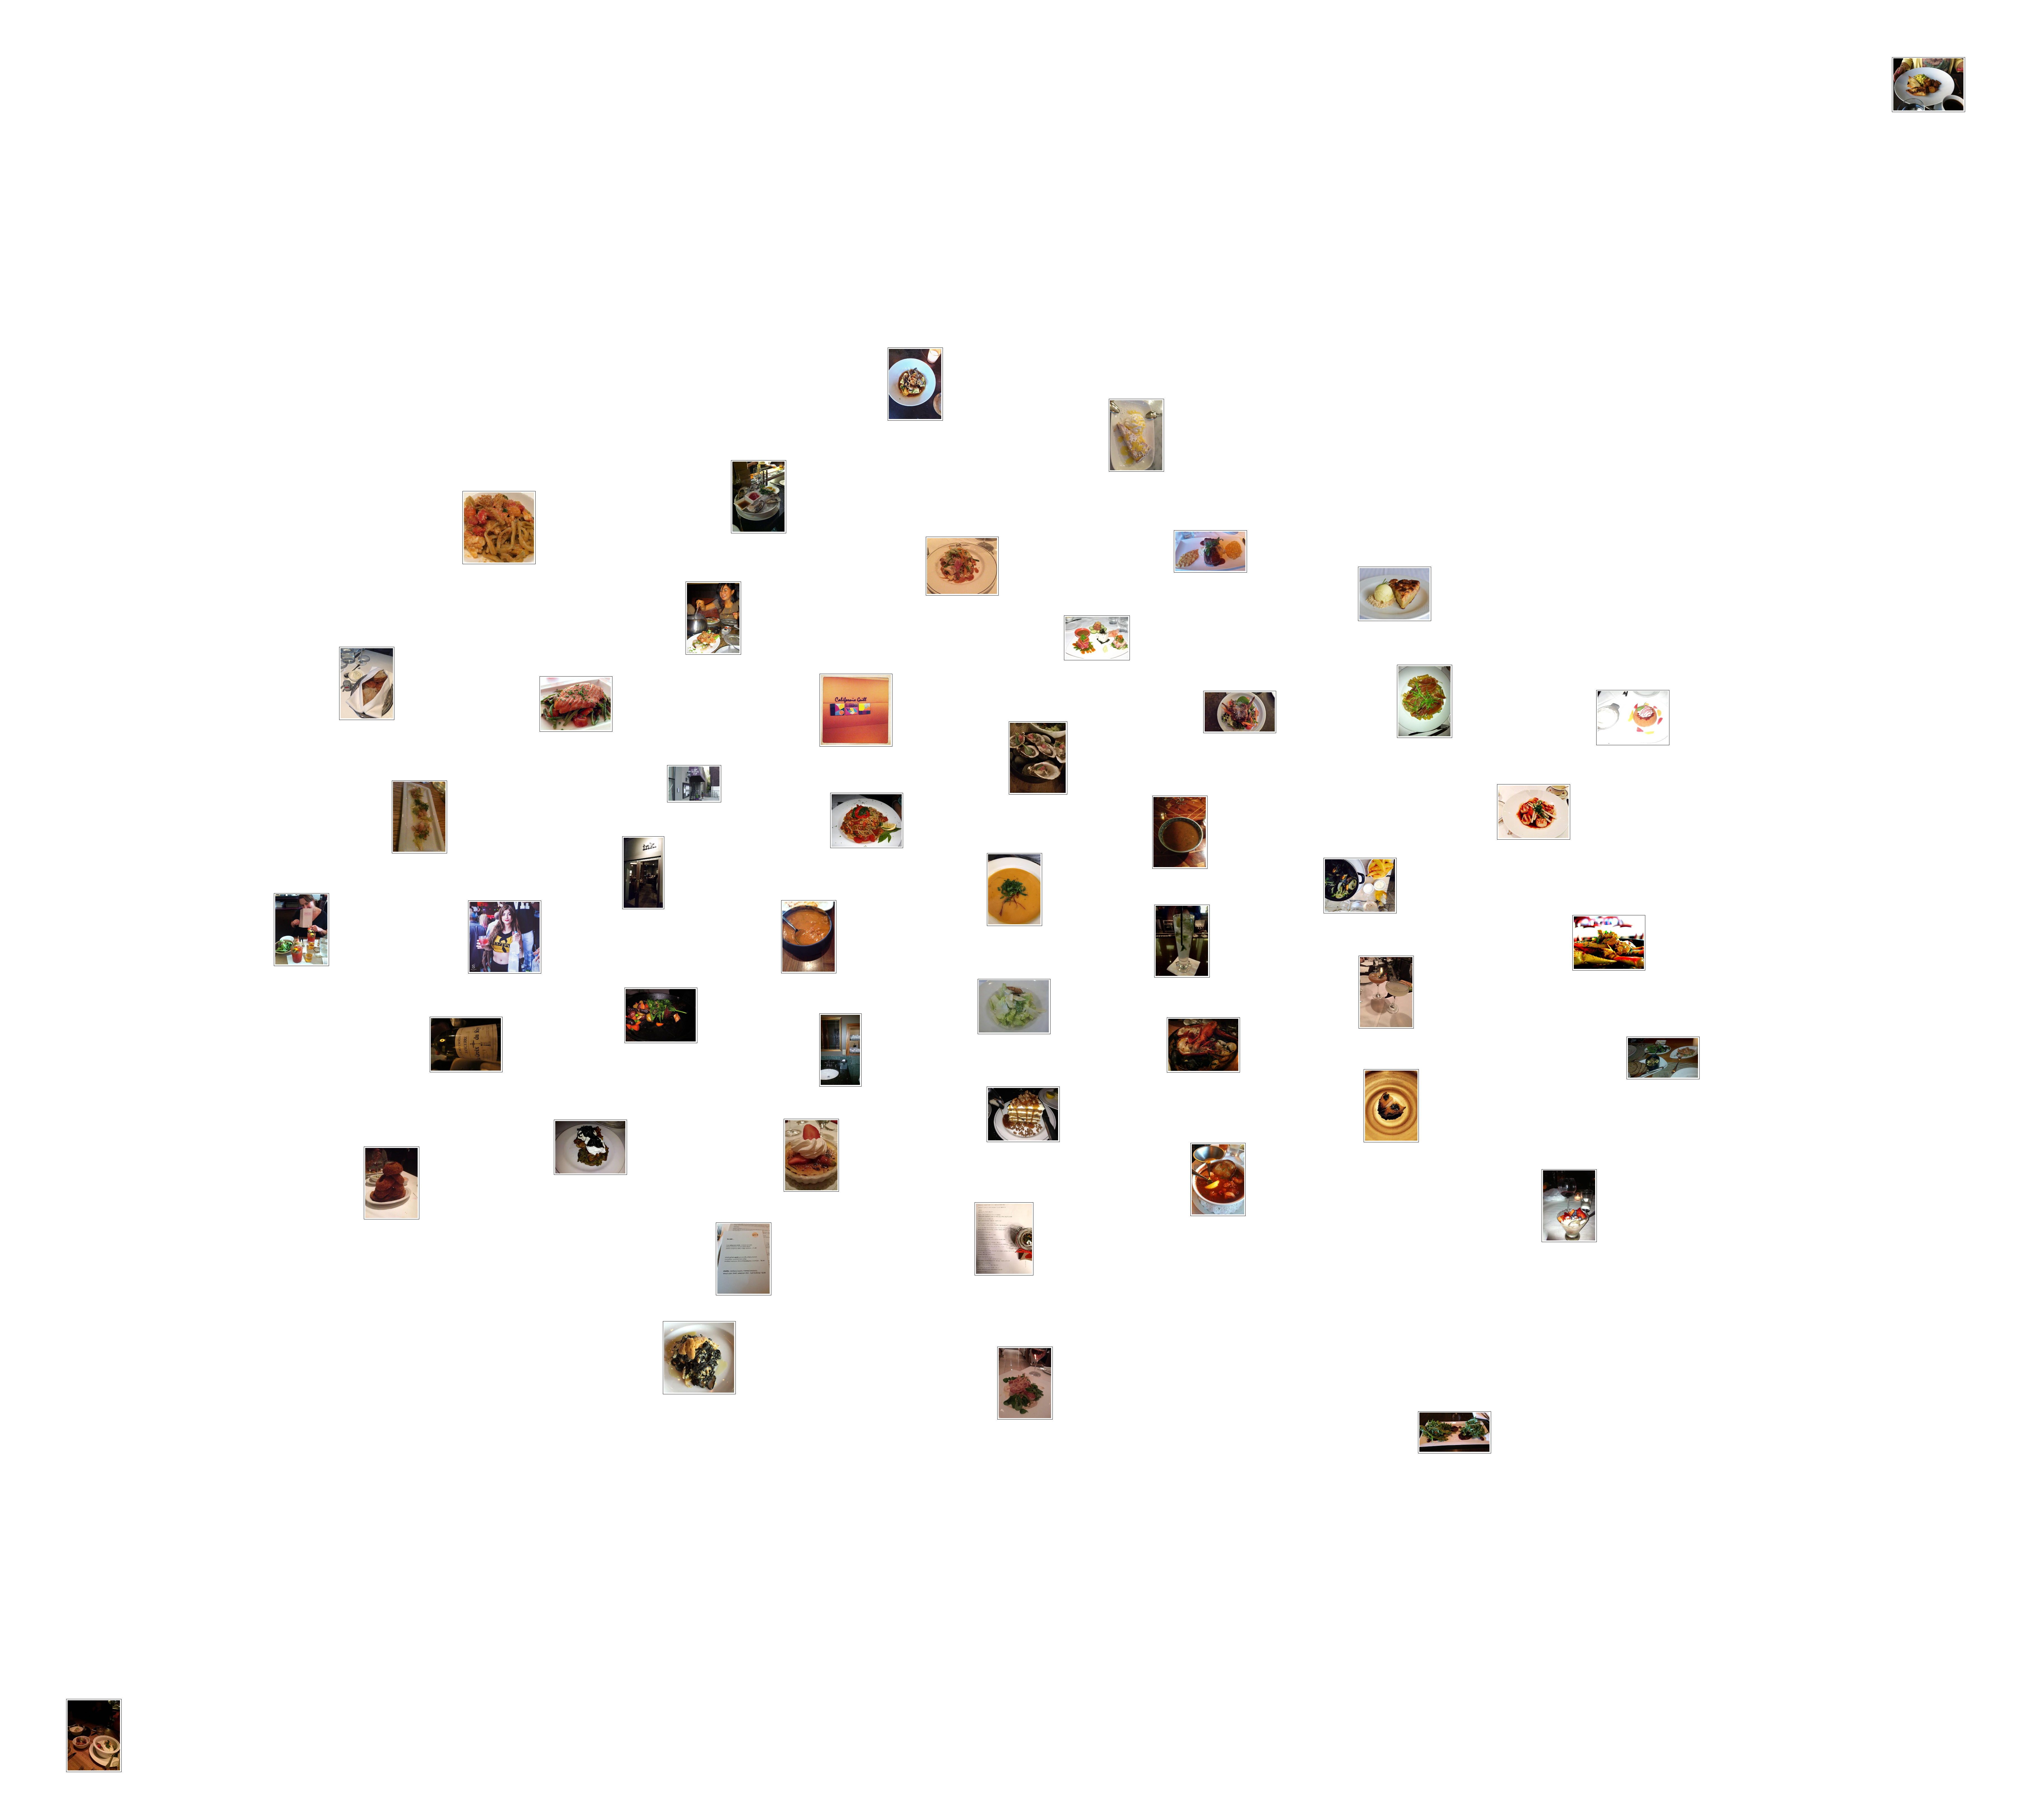

In [6]:
%pylab inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
def resizeme(image):
    img = Image.open(image)    # Open image as PIL image object
    rsize = img.resize((img.size[0]/2,img.size[1]/2)) # Use PIL to resize
    rsizeArr = np.asarray(rsize)  # Get array back
    return rsizeArr


from matplotlib import offsetbox
def plot_tsne(X, X_embedded, name, min_dist=3.0):
    #plt.ioff()
    num_images = len(X)
    fig = figure(figsize=(100,100))
    ax = axes(frameon=False)
    setp(ax, xticks=(), yticks=())
    subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=np.zeros((num_images)), marker="x")
    count =0
    if min_dist is not None:
        shown_images = np.array([[10., 10.]])
        for i in range(len(X_embedded)):
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            count+=1
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i],cmap=cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)
    fig.savefig("tSNE-expensive_biz.jpg")
    print "\n\nNumber of images shown: ", count  
    print "Saved to: tSNE_expensive_biz.jpg"

#X is a list of RGB-images. X[i] has dimension (Width,Height,3 )    
X = [resizeme(image) for image in expensive_images]
#plt.ioff()  ## Not print pictures in this notebook. This will save time
plot_tsne(X, X_train_embedded,"t-SNE", min_dist=1.0) 